In [1]:
library(readr)
library(tidyr)
library(dplyr)
library(ggplot2)
library(purrr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
ames_df <-
  read_csv("ames_housing_data.csv",
           col_types = list("PoolQC" = col_character()))

New names:
• `` -> `...1`


In [5]:
ames_df$TotalSF <- ames_df$FirstFlrSF + ames_df$SecondFlrSF
ames_df$logSalePrice <- log(ames_df$SalePrice)
ames_df$price_sqft <- ames_df$SalePrice / ames_df$TotalSF
ames_df$TotalBsmtSF <- ames_df$BsmtFinSF1 + ames_df$BsmtFinSF2 + ames_df$BsmtUnfSF

In [6]:
# Subset the data; drop-out waterfall and 20 variables for EDA
subset_df <- ames_df %>%
  filter(
    Zoning %in% c("RH", "RL", "RP", "RM", "FV"),
    BldgType == "1Fam",
    SaleCondition == "Normal",
    GrLivArea < 4000
  )

# Drop Condition waterfall
knitr::kable(
  tibble(
    `Drop Condition` = c(
      "Non-Residential Zoning",
      "Multi-Family Homes",
      "Non-Normal Sale Conditions",
      "Recommended Exclusions"
    ),
    `Observations Dropped` = c(29, 502, 411, 1),
    `Remaining Observations` = c(2901, 2399, 1988, 1987)
  )
)



|Drop Condition             | Observations Dropped| Remaining Observations|
|:--------------------------|--------------------:|----------------------:|
|Non-Residential Zoning     |                   29|                   2901|
|Multi-Family Homes         |                  502|                   2399|
|Non-Normal Sale Conditions |                  411|                   1988|
|Recommended Exclusions     |                    1|                   1987|

In [7]:
model_df <- subset_df %>%
  select(
    SalePrice,
    logSalePrice,
    LotFrontage,
    LotArea,
    MasVnrArea,
    BsmtFinSF1,
    BsmtFinSF2,
    BsmtUnfSF,
    FirstFlrSF,
    SecondFlrSF,
    LowQualFinSF,
    GrLivArea,
    GarageArea,
    WoodDeckSF,
    OpenPorchSF,
    ThreeSsnPorch,
    ScreenPorch,
    PoolArea,
    MiscVal,
    TotalSF,
    price_sqft,
    OverallQual,
    TotalBsmtSF
  )

In [8]:
myfunct1 <- function(x) {
  c(
    "SD" = round(sd(x, na.rm = TRUE), digits = 0),
    "Mean" = round(mean(x, na.rm = TRUE), digits = 2),
    "Med" = round(median(x ,na.rm = TRUE), digits = 0),
    "Min" = round(min(x, na.rm = TRUE), digits = 0),
    "Max" = round(max(x, na.rm = TRUE), digits = 0)
  )
}

summary_numeric_df <- model_df %>%
  map( ~ myfunct1(.)) %>%
  as.data.frame()

row_names <- row.names(summary_numeric_df)

summary_numeric_df <- cbind(summary_numeric_df, row_names) %>%
  gather(key = key, value = value,-row_names) %>%
  spread(key = row_names, value = value)

knitr::kable(summary_numeric_df)



|key           |    Max|      Mean|    Med|   Min|    SD|
|:-------------|------:|---------:|------:|-----:|-----:|
|BsmtFinSF1    |   2288|    441.30|    390|     0|   419|
|BsmtFinSF2    |   1526|     58.25|      0|     0|   181|
|BsmtUnfSF     |   2336|    534.68|    458|     0|   402|
|FirstFlrSF    |   3820|   1146.44|   1065|   334|   360|
|GarageArea    |   1488|    469.16|    473|     0|   201|
|GrLivArea     |   3820|   1495.67|   1450|   334|   492|
|logSalePrice  |     13|     12.03|     12|    10|     0|
|LotArea       | 215245|  10802.17|   9750|  2500|  7772|
|LotFrontage   |    313|     72.89|     70|    30|    20|
|LowQualFinSF  |   1064|      4.87|      0|     0|    49|
|MasVnrArea    |   1600|     94.20|      0|     0|   171|
|MiscVal       |  15500|     54.33|      0|     0|   529|
|OpenPorchSF   |    570|     46.36|     25|     0|    65|
|OverallQual   |     10|      6.01|      6|     1|     1|
|PoolArea      |    800|      2.16|      0|     0|    35|
|price_sqft 

In [9]:
myfunct2 <- function(x) {
  c(
    "NA Observations" = round(sum(is.na(x)))
    #"Zero Obs" = round(sum(if_else(x == 0, 1, 0)))
  )
}

na_df <- model_df %>%
  map( ~ myfunct2(.)) %>%
  as.data.frame()

row_names <- row.names(na_df)

na_df <- cbind(na_df, row_names) %>%
  gather(key = key, value = value,-row_names) %>%
  spread(key = row_names, value = value)

na_df %>%
  mutate(Variable = key) %>%
  select(Variable, `NA Observations`) %>%
  filter(`NA Observations` > 0) %>%
  knitr::kable()



|Variable    | NA Observations|
|:-----------|---------------:|
|LotFrontage |             384|
|MasVnrArea  |              11|

In [10]:
model_df <- model_df %>%
  mutate(
    LotFrontage = replace_na(LotFrontage, median(LotFrontage, na.rm = TRUE)),
    MasVnrArea = replace_na(MasVnrArea, 0)
  )

In [11]:
## Summary table of numeric variables
myfunct3 <- function(x) {
  c("Zero Obs" = round(sum(if_else(x == 0, 1, 0))))
}

zero_df <- model_df %>%
  map(~ myfunct3(.)) %>%
  as.data.frame()

row_names <- row.names(zero_df)

zero_df <- cbind(zero_df, row_names) %>%
  gather(key = key, value = value, -row_names) %>%
  spread(key = row_names, value = value)

zero_df %>%
  mutate(
    "Zero Obs Percent" = scales::percent(`Zero Obs` / nrow(model_df), accuracy = 3L),
    Variable = key
  ) %>%
  select(Variable, `Zero Obs`, `Zero Obs Percent`) %>%
  knitr::kable()



|Variable      | Zero Obs|Zero Obs Percent |
|:-------------|--------:|:----------------|
|BsmtFinSF1    |      589|30%              |
|BsmtFinSF2    |     1708|87%              |
|BsmtUnfSF     |      144|6%               |
|FirstFlrSF    |        0|0%               |
|GarageArea    |       71|3%               |
|GrLivArea     |        0|0%               |
|logSalePrice  |        0|0%               |
|LotArea       |        0|0%               |
|LotFrontage   |        0|0%               |
|LowQualFinSF  |     1962|99%              |
|MasVnrArea    |     1242|63%              |
|MiscVal       |     1902|96%              |
|OpenPorchSF   |      912|45%              |
|OverallQual   |        0|0%               |
|PoolArea      |     1978|99%              |
|price_sqft    |        0|0%               |
|SalePrice     |        0|0%               |
|ScreenPorch   |     1798|90%              |
|SecondFlrSF   |     1120|57%              |
|ThreeSsnPorch |     1962|99%              |
|TotalBs

In [12]:
model_df <- model_df %>%
  select(
    GarageArea,
    GrLivArea,
    logSalePrice,
    LotArea,
    LotFrontage,
    OverallQual,
    price_sqft,
    SalePrice,
    TotalBsmtSF,
    TotalSF
  )

vars_tbl <- tibble("Variable" = names(model_df))
knitr::kable(vars_tbl)



|Variable     |
|:------------|
|GarageArea   |
|GrLivArea    |
|logSalePrice |
|LotArea      |
|LotFrontage  |
|OverallQual  |
|price_sqft   |
|SalePrice    |
|TotalBsmtSF  |
|TotalSF      |

In [13]:
model_df <- model_df %>%
  filter(TotalBsmtSF > 0 & GarageArea >0)

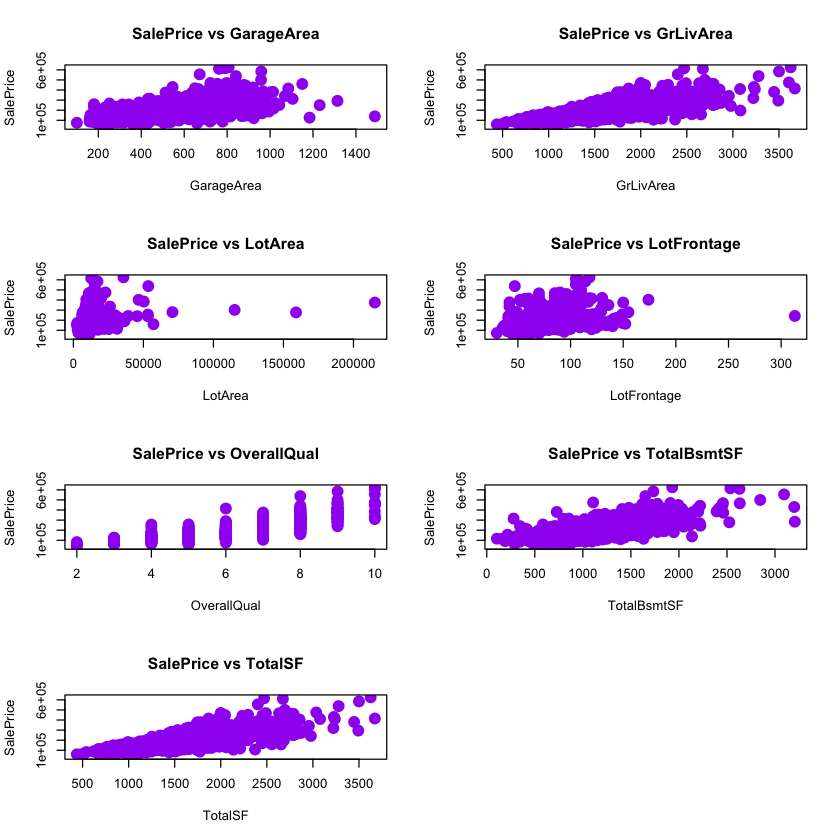

In [14]:
par(mfrow = c(4, 2))


sub_df <- model_df %>%
  select(
    SalePrice,
    GarageArea,
    GrLivArea,
    LotArea,
    LotFrontage,
    OverallQual,
    TotalBsmtSF,
    TotalSF
  )

for (i in 2:length(sub_df)) {
  plot(
    x = sub_df[[i]],
    y = sub_df[[1]],
    main = paste(names(sub_df[, 1]), "vs", names(sub_df[, i])),
    xlab = names(sub_df[, i]),
    ylab = names(sub_df[, 1]),
    col = "purple",
    pch = 16,
    cex = 2
  )
}

corrplot 0.92 loaded



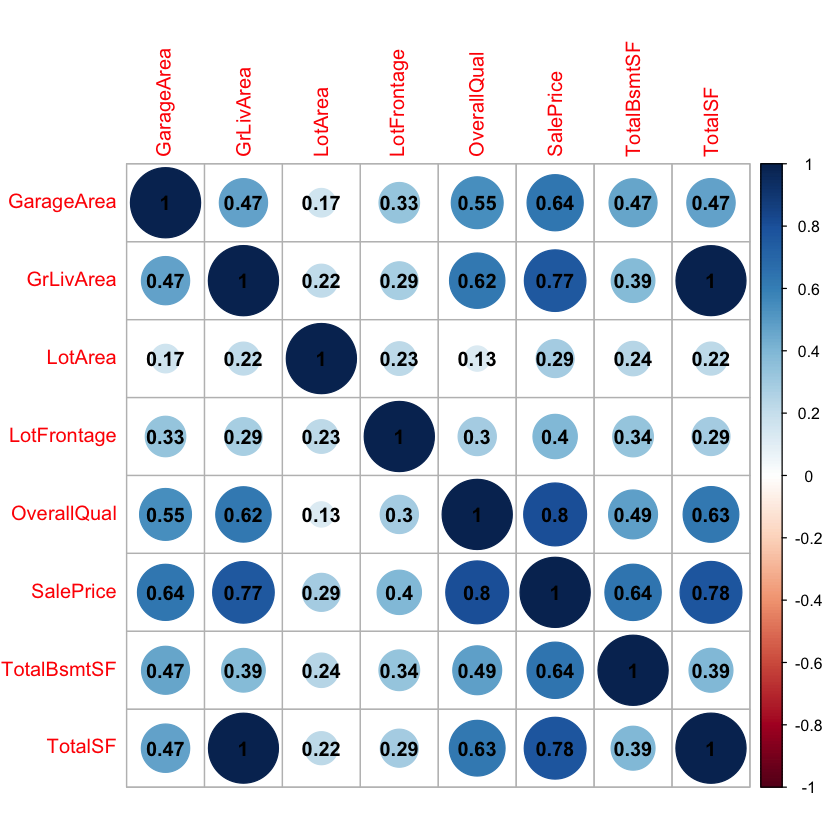

In [18]:
library(corrplot)
model_df %>%
  select(-logSalePrice, -price_sqft) %>%
  cor() %>%
  corrplot::corrplot(addCoef.col = TRUE)

In [19]:
LotAreaOutliers <- boxplot.stats(model_df$LotArea, coef = 3.0)$out
LotFrontageOutliers <- boxplot.stats(model_df$LotFrontage, coef = 3.0)$out
GarageAreaOutliers <- boxplot.stats(model_df$GarageArea, coef = 3.0)$out

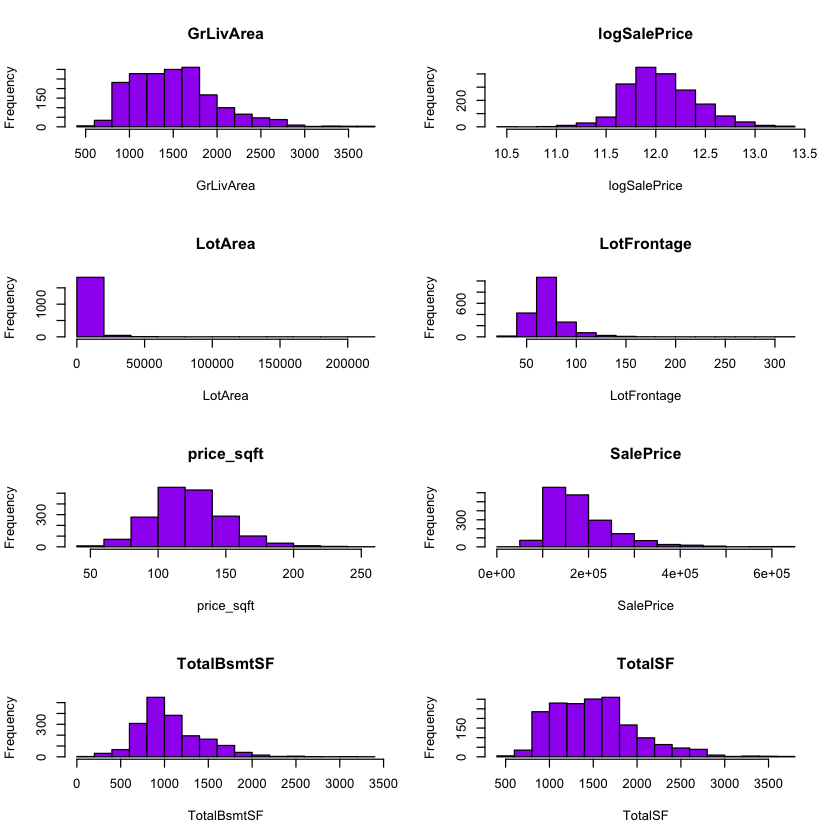

In [20]:
par(mfrow = c(4,2))

# Histograms for all continous variables
hist_df <- model_df %>% select(-OverallQual)

for (i in 2:length(hist_df)) {
  hist(
    x = hist_df[[i]],
    main = names(hist_df[, i]),
    xlab = names(hist_df[, i]),
    col = "purple",
  )
}

In [21]:
model_df <- model_df %>%
  filter(
    !LotArea %in% LotAreaOutliers,!LotFrontage %in% LotFrontageOutliers,!GarageArea %in% GarageAreaOutliers
  )

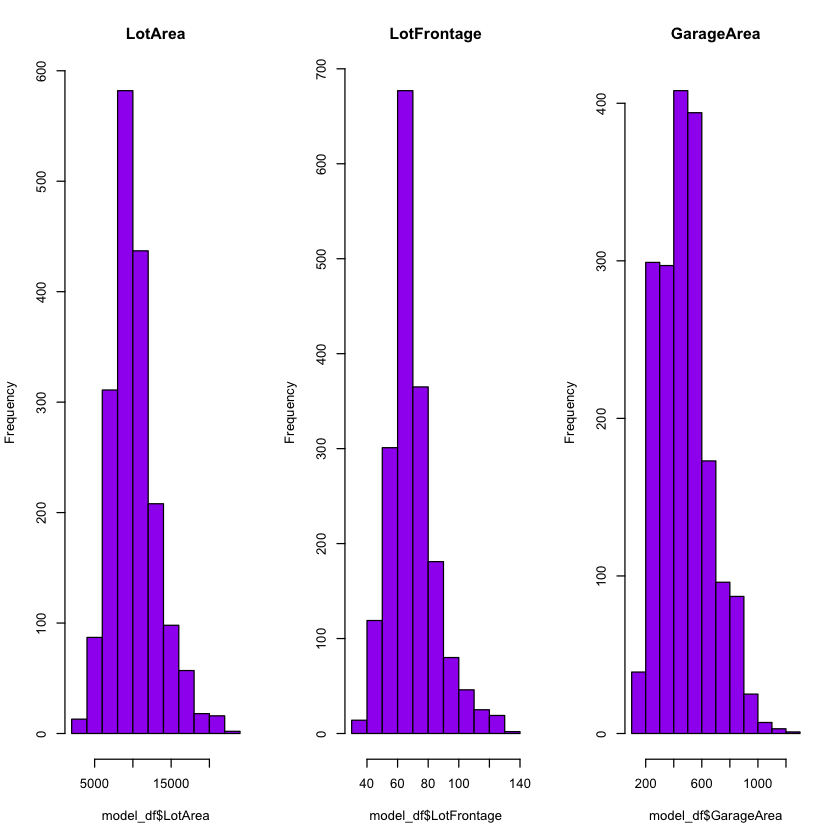

In [22]:
par(mfrow = c(1, 3))

hist(model_df$LotArea, col = "purple", main = "LotArea")
hist(model_df$LotFrontage, col = "purple", main = "LotFrontage")
hist(model_df$GarageArea, col = "purple", main = "GarageArea")

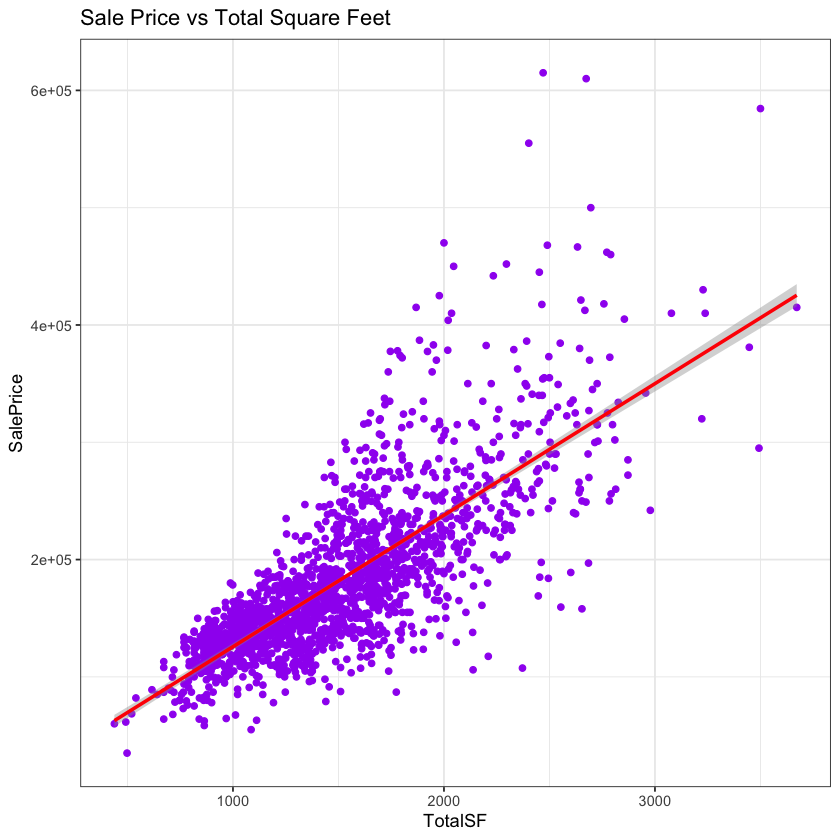

In [23]:
model_df %>%
  ggplot(aes(x = TotalSF, y = SalePrice)) +
  geom_point(color = "purple") +
  geom_smooth(formula = y ~ x, method = "lm", color = "red") +
  ggtitle("Sale Price vs Total Square Feet") +
  theme_bw()

In [24]:
model_1 <- lm(model_df$SalePrice ~ model_df$TotalSF)
summary(model_1)


Call:
lm(formula = model_df$SalePrice ~ model_df$TotalSF)

Residuals:
    Min      1Q  Median      3Q     Max 
-172070  -24028   -2243   18991  324439 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      13549.890   3421.962    3.96 7.79e-05 ***
model_df$TotalSF   112.150      2.173   51.62  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 44220 on 1827 degrees of freedom
Multiple R-squared:  0.5932,	Adjusted R-squared:  0.593 
F-statistic:  2664 on 1 and 1827 DF,  p-value: < 2.2e-16


2e

In [25]:
model_2_pred <- predict(model_2, model_df)
model_2_resid <- model_df$SalePrice - model_2_pred
mean_resid <- mean(model_2_resid)
std_resid <- sd(model_2_resid)
model_2_std_resid <- (model_2_resid - mean_resid) / std_resid

ERROR: Error in eval(expr, envir, enclos): object 'model_2' not found
